# Importing required libraries 

In [1]:
from kiteconnect import KiteConnect,KiteTicker
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import os 
import time
from time import sleep 
import statsmodels.api as sm
from pyotp import TOTP
from datetime import datetime
from urllib.parse import urlparse,parse_qs
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import plotly.graph_objects as go
from datetime import timedelta
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

In [2]:
def get_curr_path(folder_name):
    curr_dir = os.getcwd()
    curr_path = os.path.join(curr_dir,folder_name)
    return curr_path

def get_credentials(curr_path,file_name):
    file_dir = os.path.join(curr_path,file_name)
    file = open(file_dir,'r').read().split()
    api_key = file[0]
    api_secret = file[1]
    user_name = file[2]
    pwd = file[3]
    totp_key = file[-1]
    return api_key,api_secret,user_name,pwd,totp_key

def auto_login(api_key,user_name,pwd,totp_key):
    kite = KiteConnect(api_key=api_key)
    service = Service(ChromeDriverManager().install())
    service.start()
    options = Options()
    options.to_capabilities()
    driver = webdriver.Remote(
        command_executor=service.service_url,
        options=options)
    driver.get(kite.login_url())
    driver.implicitly_wait(5)
    username = driver.find_element(By.XPATH, "//input[@type='text']")
    username.send_keys(user_name)
    password = driver.find_element(By.XPATH, "//input[@type='password']")
    password.send_keys(pwd)
    driver.find_element(By.XPATH, "//button[@type='submit']").click()
    sleep(1)
    totp = driver.find_element(By.XPATH,"//input[@type='number']")
    totp_token = TOTP(totp_key)
    token = totp_token.now()
    totp.send_keys(token)
    driver.find_element(By.XPATH,"//button[@type = 'submit']").click()
    sleep(1)
    current_url = driver.current_url
    parsed_url = urlparse(current_url)
    query_params = parse_qs(parsed_url.query)
    request_token = query_params.get('request_token',[None])[0]
    with open('request_token.txt', 'w') as f:
        f.write(request_token)
    request_token = open('request_token.txt','r').read()
    driver.quit()
    return request_token
    

def generate_access_token(request_token,api_key,api_secret):
    request_token = open('request_token.txt','r').read()
    kite = KiteConnect(api_key=api_key)
    data = kite.generate_session(request_token=request_token,api_secret=api_secret)
    data
    with open('access_token.txt','w') as f:
        f.write(data['access_token'])
    access_token = open('access_token.txt','r').read()
    return access_token

# Automating the login in zerodha 

In [3]:
folder_name = 'api_keys'
curr_dir = get_curr_path(folder_name)

file_name = 'credentials.txt'
api_key,api_secret,user_name,pwd,totp_key = get_credentials(curr_dir,file_name)

request_token = auto_login(api_key,user_name,pwd,totp_key)

access_token = generate_access_token(request_token,api_key,api_secret)

# Setting up the access token to execute buy,sell orders

In [4]:
kite = KiteConnect(api_key=api_key)
kite.set_access_token(access_token=access_token)

In [5]:
instrument_dump = kite.instruments('NSE')
instrument_df = pd.DataFrame(instrument_dump)
instrument_df.to_csv('NSE_instruments.csv',index=False)

In [6]:
def tokenLookup(instrument_df,symbol_list):
    """Looks up instrument token for a given script from instrument dump"""
    token_list = []
    for symbol in symbol_list:
        token_list.append(int(instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]))
    return token_list

def tickerLookup(token):
    global instrument_df
    return instrument_df[instrument_df.instrument_token==token].tradingsymbol.values[0] 

def instrumentLookup(instrument_df,symbol):
    """Looks up instrument token for a given script from instrument dump"""
    try:
        return instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]
    except:
        return -1

def fetchOHLC(ticker,interval,duration):
    """extracts historical data and outputs in the form of dataframe"""
    instrument = instrumentLookup(instrument_df,ticker)
    data = pd.DataFrame(kite.historical_data(instrument,dt.date.today()-dt.timedelta(duration), dt.date.today(),interval))
    data.set_index("date",inplace=True)
    return data

def fetchOHLCExtended(ticker, inception_date, interval):
    """Extracts historical data and outputs in the form of a DataFrame.
       inception_date string format - dd-mm-yyyy"""
    instrument = instrumentLookup(instrument_df, ticker)
    from_date = dt.datetime.strptime(inception_date, '%d-%m-%Y')
    data = pd.DataFrame()  # Start with an empty DataFrame
    while True:
        if from_date.date() >= (dt.date.today() - dt.timedelta(100)):
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, dt.date.today(), interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            break
        else:
            to_date = from_date + dt.timedelta(100)
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, to_date, interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            from_date = to_date
    
    if not data.empty:
        data.set_index("date", inplace=True)
    return data



# Extracting 5 minute interval data of infosys stock

In [7]:
ohlc = fetchOHLCExtended("INFY", "31-12-2022", 'day')

In [8]:
print(ohlc.shape)
ohlc.head()

(368, 5)


,open,high,low,close,volume
date,,,,,
2023-01-02 00:00:00+05:30,1514.00,1526.50,1504.05,1524.00,3801140
2023-01-03 00:00:00+05:30,1519.85,1532.65,1515.10,1522.55,4551130
2023-01-04 00:00:00+05:30,1521.00,1521.00,1491.10,1494.80,7059590
2023-01-05 00:00:00+05:30,1505.90,1505.90,1469.25,1475.20,9868404
2023-01-06 00:00:00+05:30,1470.00,1475.00,1446.50,1448.50,6443714


# Computing the technical indicators 

In [9]:
temp_df = ohlc.copy()
temp_df.head()

,open,high,low,close,volume
date,,,,,
2023-01-02 00:00:00+05:30,1514.00,1526.50,1504.05,1524.00,3801140
2023-01-03 00:00:00+05:30,1519.85,1532.65,1515.10,1522.55,4551130
2023-01-04 00:00:00+05:30,1521.00,1521.00,1491.10,1494.80,7059590
2023-01-05 00:00:00+05:30,1505.90,1505.90,1469.25,1475.20,9868404
2023-01-06 00:00:00+05:30,1470.00,1475.00,1446.50,1448.50,6443714


In [10]:
signals_df = temp_df.copy()

# Price Actions Concepts 
<ol>
    <li>Buliish signals: Bullish Engulfing and Hammer candlesticks</li>
    <li>Bearish signals: Bearish Engulfing and Shooting Star candlesticks</li>
    <li>Support and Resistance Levels</li>
</ol>

Hammer candlesticks

In [11]:
def hammer(df):    
    """returns dataframe with hammer candle column"""
    df = df.copy()
    df["hammer"] = ((((df["high"] - df["low"])>3*(df["open"] - df["close"])) & \
                   ((df["close"] - df["low"])/(.001 + df["high"] - df["low"]) > 0.6) & \
                   ((df["open"] - df["low"])/(.001 + df["high"] - df["low"]) > 0.6)) & \
                   (abs(df["close"] - df["open"]) > 0.1* (df["high"] - df["low"]))).astype(int)
    return df

In [12]:
signals_df = hammer(signals_df)

In [13]:
signals_df[signals_df['hammer'] == 1].head()

,open,high,low,close,volume,hammer
date,,,,,,
2023-02-10 00:00:00+05:30,1612.95,1616.30,1596.45,1608.55,4786762,1
2023-03-08 00:00:00+05:30,1490.55,1496.00,1481.10,1492.70,4137080,1
2023-04-17 00:00:00+05:30,1250.30,1261.15,1185.30,1258.30,53171705,1
2023-04-24 00:00:00+05:30,1228.00,1230.00,1218.00,1226.30,8313774,1
2023-06-27 00:00:00+05:30,1280.00,1282.00,1274.20,1279.15,3240024,1


Shooting star candlesticks

In [14]:
def shooting_star(df):    
    """returns dataframe with shooting star candle column"""
    df = df.copy()
    df["shooting_star"] = ((((df["high"] - df["low"])>3*(df["open"] - df["close"])) & \
                   ((df["high"] - df["close"])/(.001 + df["high"] - df["low"]) > 0.6) & \
                   ((df["high"] - df["open"])/(.001 + df["high"] - df["low"]) > 0.6)) & \
                   (abs(df["close"] - df["open"]) > 0.1* (df["high"] - df["low"]))).astype(int)
    return df

In [15]:
signals_df = shooting_star(signals_df)

In [16]:
signals_df[signals_df['shooting_star'] == 1].tail()

,open,high,low,close,volume,hammer,shooting_star
date,,,,,,,
2024-05-06 00:00:00+05:30,1420.00,1445.7,1417.10,1425.90,6445422,0,1
2024-05-18 00:00:00+05:30,1445.00,1450.0,1442.00,1443.65,318277,0,1
2024-05-21 00:00:00+05:30,1430.00,1444.7,1428.40,1434.15,6752663,0,1
2024-06-18 00:00:00+05:30,1497.00,1507.0,1495.40,1498.20,5420939,0,1
2024-06-28 00:00:00+05:30,1572.55,1588.5,1564.25,1566.75,8197544,0,1


Bullish Engulfing and Bearish Engulfing 

In [17]:
def signal(df):
    df = df.copy()
    length = len(df)
    high = list(df['high'])
    low = list(df['low'])
    close = list(df['close'])
    open = list(df['open'])
    signal = [0] * length # [0,1,2] 0: no engulfing, 1: bearish, 2: bullish
    bodydiff = [0] * length # abs diff of the close and opening 
    
    for row in range(1, length):
        bodydiff[row] = abs(open[row]-close[row])
        bodydiffmin = 0.003
        if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
            open[row-1]<close[row-1] and
            open[row]>close[row] and 
            #open[row]>=close[row-1] and close[row]<open[row-1]):
            (open[row]-close[row-1])>=+0e-5 and close[row]<open[row-1]):
            signal[row] = 1
        elif (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
            open[row-1]>close[row-1] and
            open[row]<close[row] and 
            #open[row]<=close[row-1] and close[row]>open[row-1]):
            (open[row]-close[row-1])<=-0e-5 and close[row]>open[row-1]):
            signal[row] = 2
        else:
            signal[row] = 0
        #signal[row]=random.choice([0, 1, 2])
        #signal[row]=1
    return signal

# engulf_df['engulf_bullish_bearish'] = signal(engulf_df)

In [18]:
signals_df['bullish_bearish_engulfing'] = signal(signals_df)

#bullish engulfing candles 
signals_df[signals_df['bullish_bearish_engulfing'] == 2].tail()

,open,high,low,close,volume,hammer,shooting_star,bullish_bearish_engulfing
date,,,,,,,,
2023-11-22 00:00:00+05:30,1436.20,1458.95,1436.20,1457.80,3108786,0,0,2
2024-02-06 00:00:00+05:30,1686.75,1733.00,1673.95,1729.45,7694265,0,0,2
2024-03-12 00:00:00+05:30,1600.00,1625.00,1597.65,1612.95,4614222,0,0,2
2024-06-27 00:00:00+05:30,1538.45,1578.40,1532.05,1573.35,14757754,0,0,2
2024-07-01 00:00:00+05:30,1559.50,1599.90,1559.50,1590.80,6801771,0,0,2


In [19]:
#bearish engulfing candles 
signals_df[signals_df['bullish_bearish_engulfing'] == 1].tail()

,open,high,low,close,volume,hammer,shooting_star,bullish_bearish_engulfing
date,,,,,,,,
2023-11-08 00:00:00+05:30,1405.00,1405.00,1386.45,1391.00,3550635,0,0,1
2023-12-01 00:00:00+05:30,1459.90,1459.90,1446.15,1452.30,3489187,0,0,1
2023-12-05 00:00:00+05:30,1465.80,1466.90,1442.00,1453.95,5123039,0,0,1
2024-01-20 00:00:00+05:30,1665.55,1669.25,1645.00,1648.85,1158144,0,0,1
2024-03-27 00:00:00+05:30,1496.00,1499.00,1481.55,1483.85,6857402,0,0,1


# Support and Resistance 

In [20]:
signals_df.to_csv('signals.csv')

Inferring the logic from <b>fractal candlestick patterns</b>  to identify the key levels

In [21]:
def find_support(df):
    df = df.copy()
    supports = df[df.low == df.low.rolling(5, center=True).min()].low
    return supports

def find_resistance(df):
    df = df.copy()
    resistance = df[df.high == df.high.rolling(5, center=True).max()].high
    return resistance

supports = find_support(signals_df)
resistances = find_resistance(signals_df)
print(supports[:5])
print(resistances[:5])


date
2023-01-06 00:00:00+05:30    1446.5
2023-01-20 00:00:00+05:30    1524.0
2023-01-27 00:00:00+05:30    1507.4
2023-02-07 00:00:00+05:30    1555.1
2023-02-13 00:00:00+05:30    1566.0
Name: low, dtype: float64
date
2023-01-18 00:00:00+05:30    1551.85
2023-01-24 00:00:00+05:30    1568.80
2023-02-03 00:00:00+05:30    1604.65
2023-02-09 00:00:00+05:30    1619.75
2023-02-16 00:00:00+05:30    1614.45
Name: high, dtype: float64


In [22]:
levels = pd.concat([supports,resistances])
levels.head()

date
2023-01-06 00:00:00+05:30    1446.5
2023-01-20 00:00:00+05:30    1524.0
2023-01-27 00:00:00+05:30    1507.4
2023-02-07 00:00:00+05:30    1555.1
2023-02-13 00:00:00+05:30    1566.0
dtype: float64

In [72]:
len(levels)

107

In [65]:
s = np.mean(signals_df['high'] - signals_df['low']) 

In [66]:
def is_far_from_level(l,levels,s):
    return np.sum([abs(l - levels[i]) < s for i in range(len(levels))]) == 0


In [67]:
filtered_levels = []
corresponding_dates =  []
for date,level in levels.items():
    if is_far_from_level(level,filtered_levels,s):
        filtered_levels.append(level)
        corresponding_dates.append(date)
        
        

In [68]:
def plot_all(df, filtered_levels):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price')

    for level in filtered_levels:
        plt.axhline(y=level, color='blue', linestyle='-', linewidth=0.5)

    plt.legend()
    plt.title('Support and Resistance Levels')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


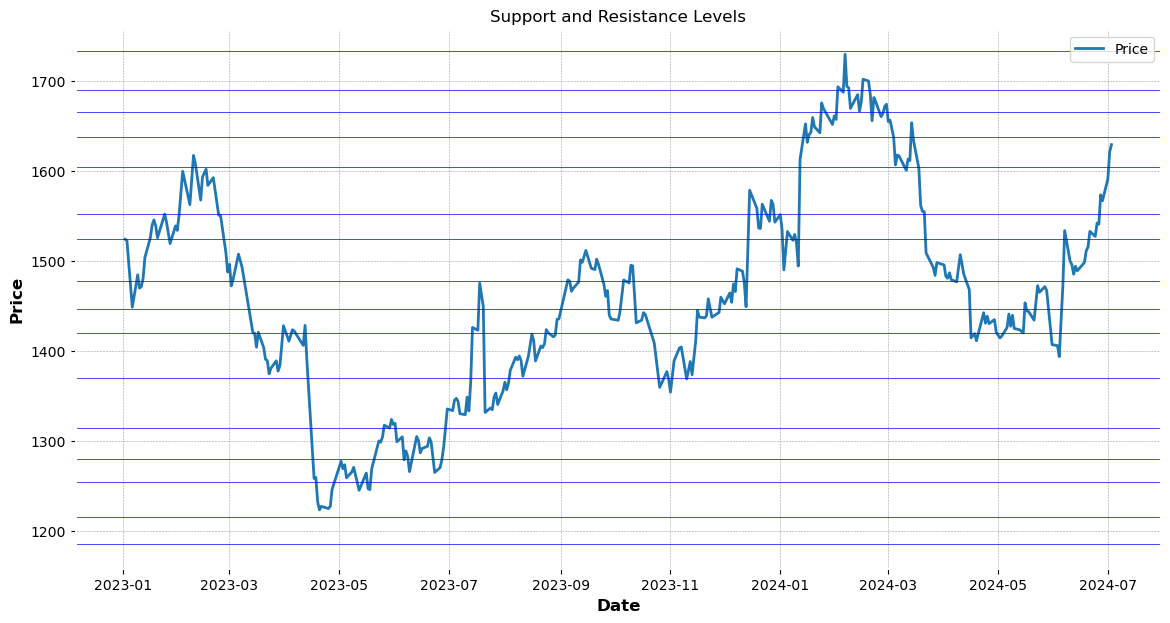

In [69]:
plot_all(signals_df, filtered_levels)


In [73]:
len(filtered_levels)

16

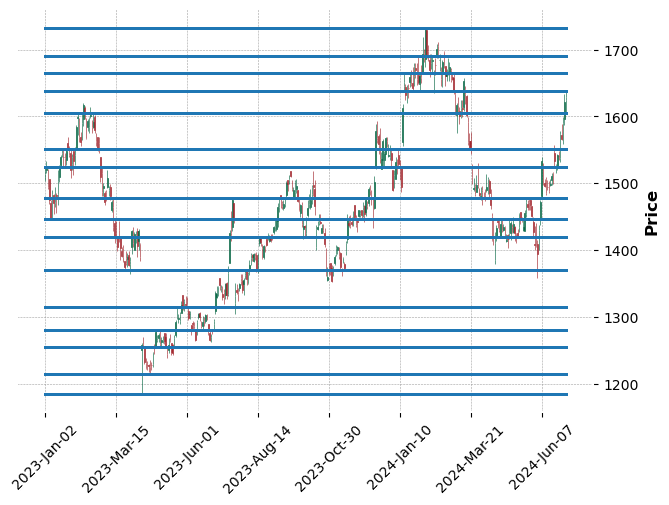

In [70]:
mpf.plot(signals_df,type='candle',hlines=filtered_levels,style='charles')

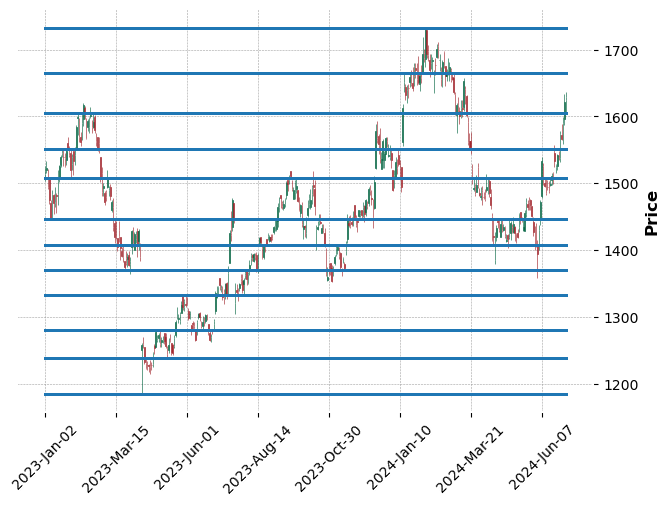

In [63]:
significant_levels = []
step = len(filtered_levels) // 10  # Keep 1 out of every 10 levels
for i in range(0, len(filtered_levels), step):
    significant_levels.append(filtered_levels[i])
mpf.plot(signals_df,type='candle',hlines=significant_levels,style='charles')

# Manual Backtesting 

In [ ]:
def generate_buy_sell(df, aligned_zones_with_levels, profit_percentage, loss_percentage, capital):
    df = df.copy()
    pos = False
    trades = []
    buy_price, stop_loss, take_profit, total_profit_loss = 0, 0, 0, 0

    for i in range(len(df)):
        current_price = df['close'].iloc[i]

        # Check if current price is near any support or resistance level
        nearest_support = None
        nearest_resistance = None
        for level_1, level_2 in aligned_zones_with_levels:
            if level_1[2] == 'support' and abs(level_1[1] - current_price) / current_price < 0.02:
                nearest_support = level_1[1]
            if level_2[2] == 'support' and abs(level_2[1] - current_price) / current_price < 0.02:
                nearest_support = level_2[1]
            if level_1[2] == 'resistance' and abs(level_1[1] - current_price) / current_price < 0.02:
                nearest_resistance = level_1[1]
            if level_2[2] == 'resistance' and abs(level_2[1] - current_price) / current_price < 0.02:
                nearest_resistance = level_2[1]

        if not pos and nearest_support is not None:
            # Entry condition for long position
            if (df['bullish_bearish_engulfing'].iloc[i] == 2 or df['hammer'].iloc[i] == 1):
                buy_price = current_price
                quantity = capital // buy_price
                if quantity == 0:
                    print(f"Insufficient capital to buy stocks at index {i}")
                    continue 
                total_buy_price = buy_price * quantity
                stop_loss = buy_price - (buy_price * (loss_percentage / 100))
                take_profit = buy_price + (buy_price * (profit_percentage / 100))
                buy_date = df.index[i]
                pos = True
                capital -= total_buy_price
                print(f"Buy Signal: price: {buy_price}, stop loss: {stop_loss}, take profit: {take_profit}, capital: {capital}, quantity: {quantity}, date: {df.index[i]}")

        elif pos:
            # Trailing stop loss update
            if (df['bullish_bearish_engulfing'].iloc[i] == 1 or df['shooting_star'].iloc[i] == 1) or (current_price <= stop_loss) or (current_price >= take_profit):
                sell_price = current_price
                total_sell_price = sell_price * quantity
                capital += total_sell_price
                profit_loss = sell_price - buy_price
                total_profit_loss = total_sell_price - total_buy_price
                trades.append({
                    'buy_date': buy_date,
                    'buy_price': buy_price,
                    'target_profit': take_profit,
                    'stop_loss': stop_loss,
                    'total_buy_price': total_buy_price,
                    'quantity': quantity,
                    'sell_date': df.index[i],
                    'sell_price': sell_price,
                    'total_selling_price': total_sell_price,
                    'profit_loss': profit_loss,
                    'total_profit_loss': total_profit_loss,
                    'available_capital': capital
                })
                pos = False
                print(f"Sell Signal: price: {sell_price}, total selling price: {total_sell_price}, capital: {capital}, date: {df.index[i]}")

    return trades, total_profit_loss


# Example usage
trades, total_profit_loss = generate_buy_sell(signals_df, aligned_zones_with_levels, profit_percentage=3, loss_percentage=2, capital=10000)

print("\nTrade Summary:")
for trade in trades:
    print(f"Bought at {trade['buy_price']} on {trade['buy_date']} and sold at {trade['sell_price']} on {trade['sell_date']}, Profit/Loss: {trade['profit_loss']:.2f}")

print(f"\nTotal Profit/Loss: {total_profit_loss:.2f}")


NameError: name 'aligned_zones_with_levels' is not defined

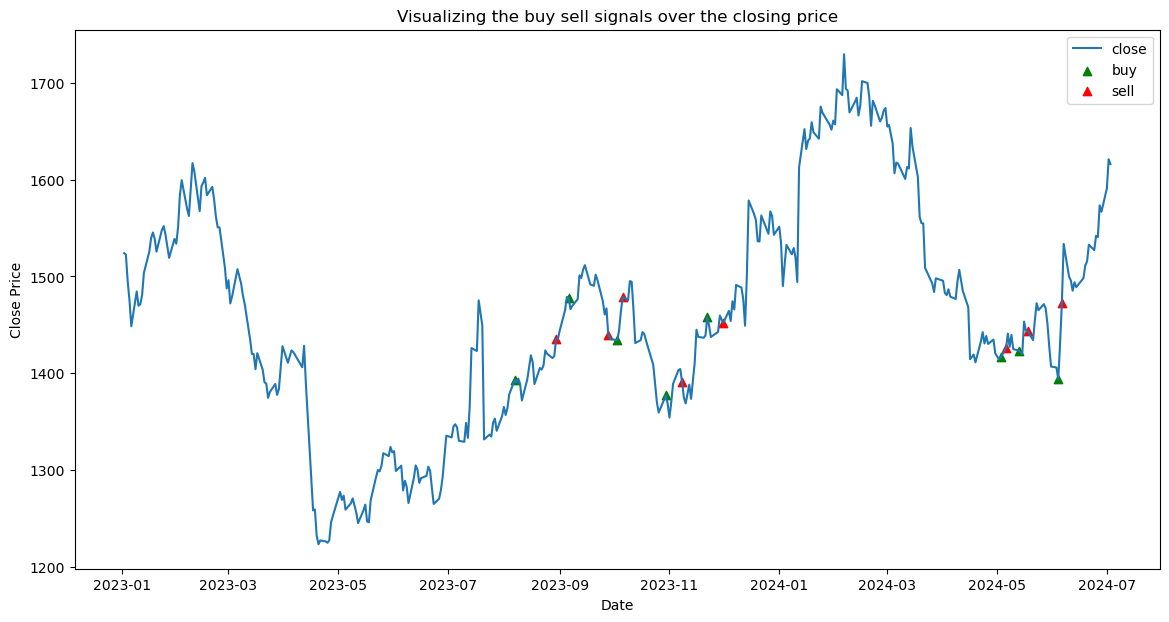

In [ ]:
buy_signals = [trade['buy_price'] for trade in trades]
sell_signals = [trade['sell_price'] for trade in trades]
sell_time = [trade['sell_date'] for trade in trades]
buy_time = [trade['buy_date'] for trade in trades]
plt.figure(figsize=(14, 7))
plt.plot(signals_df.index,signals_df['close'],label='close')
plt.scatter(buy_time,buy_signals,marker='^',color='green',label='buy',alpha=1)
plt.scatter(sell_time,sell_signals,marker='^',color='red',label='sell',alpha=1)
plt.title('Visualizing the buy sell signals over the closing price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
trades_df = pd.DataFrame(trades)
trades_df['buy_date'] = pd.to_datetime(trades_df['buy_date'])
trades_df['sell_date'] = pd.to_datetime(trades_df['sell_date'])
print(len(trades_df[trades_df['profit_loss'] > 0]))
trades_df[trades_df['profit_loss'] > 0]

6


,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
0,2023-08-07 00:00:00+05:30,1393.00,1434.7900,1365.140,9751.00,7.0,2023-08-30 00:00:00+05:30,1435.15,10046.05,42.15,295.05,10295.05
2,2023-10-03 00:00:00+05:30,1434.00,1477.0200,1405.320,10038.00,7.0,2023-10-06 00:00:00+05:30,1478.70,10350.90,44.70,312.90,10379.95
3,2023-10-30 00:00:00+05:30,1377.05,1418.3615,1349.509,9639.35,7.0,2023-11-08 00:00:00+05:30,1391.00,9737.00,13.95,97.65,10477.60
5,2024-05-03 00:00:00+05:30,1416.30,1458.7890,1387.974,9914.10,7.0,2024-05-06 00:00:00+05:30,1425.90,9981.30,9.60,67.20,10506.30
6,2024-05-13 00:00:00+05:30,1423.45,1466.1535,1394.981,9964.15,7.0,2024-05-18 00:00:00+05:30,1443.65,10105.55,20.20,141.40,10647.70
7,2024-06-04 00:00:00+05:30,1393.65,1435.4595,1365.777,9755.55,7.0,2024-06-06 00:00:00+05:30,1472.25,10305.75,78.60,550.20,11197.90


In [ ]:
trades_df[trades_df['profit_loss'] < 0]

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
1,2023-09-06 00:00:00+05:30,1477.45,1521.7735,1447.901,8864.7,6.0,2023-09-28 00:00:00+05:30,1439.45,8636.7,-38.0,-228.0,10067.05
4,2023-11-22 00:00:00+05:30,1457.80,1501.5340,1428.644,10204.6,7.0,2023-12-01 00:00:00+05:30,1452.30,10166.1,-5.5,-38.5,10439.10


In [ ]:
# trades_df.head

In [ ]:
trades_df.tail()

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
3,2023-10-30 00:00:00+05:30,1377.05,1418.3615,1349.509,9639.35,7.0,2023-11-08 00:00:00+05:30,1391.00,9737.00,13.95,97.65,10477.6
4,2023-11-22 00:00:00+05:30,1457.80,1501.5340,1428.644,10204.60,7.0,2023-12-01 00:00:00+05:30,1452.30,10166.10,-5.50,-38.50,10439.1
5,2024-05-03 00:00:00+05:30,1416.30,1458.7890,1387.974,9914.10,7.0,2024-05-06 00:00:00+05:30,1425.90,9981.30,9.60,67.20,10506.3
6,2024-05-13 00:00:00+05:30,1423.45,1466.1535,1394.981,9964.15,7.0,2024-05-18 00:00:00+05:30,1443.65,10105.55,20.20,141.40,10647.7
7,2024-06-04 00:00:00+05:30,1393.65,1435.4595,1365.777,9755.55,7.0,2024-06-06 00:00:00+05:30,1472.25,10305.75,78.60,550.20,11197.9


In [ ]:
trades_df

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital
0,2023-08-07 00:00:00+05:30,1393.00,1434.7900,1365.140,9751.00,7.0,2023-08-30 00:00:00+05:30,1435.15,10046.05,42.15,295.05,10295.05
1,2023-09-06 00:00:00+05:30,1477.45,1521.7735,1447.901,8864.70,6.0,2023-09-28 00:00:00+05:30,1439.45,8636.70,-38.00,-228.00,10067.05
2,2023-10-03 00:00:00+05:30,1434.00,1477.0200,1405.320,10038.00,7.0,2023-10-06 00:00:00+05:30,1478.70,10350.90,44.70,312.90,10379.95
3,2023-10-30 00:00:00+05:30,1377.05,1418.3615,1349.509,9639.35,7.0,2023-11-08 00:00:00+05:30,1391.00,9737.00,13.95,97.65,10477.60
4,2023-11-22 00:00:00+05:30,1457.80,1501.5340,1428.644,10204.60,7.0,2023-12-01 00:00:00+05:30,1452.30,10166.10,-5.50,-38.50,10439.10
5,2024-05-03 00:00:00+05:30,1416.30,1458.7890,1387.974,9914.10,7.0,2024-05-06 00:00:00+05:30,1425.90,9981.30,9.60,67.20,10506.30
6,2024-05-13 00:00:00+05:30,1423.45,1466.1535,1394.981,9964.15,7.0,2024-05-18 00:00:00+05:30,1443.65,10105.55,20.20,141.40,10647.70
7,2024-06-04 00:00:00+05:30,1393.65,1435.4595,1365.777,9755.55,7.0,2024-06-06 00:00:00+05:30,1472.25,10305.75,78.60,550.20,11197.90


# Computing the absolute returns 


absolute returns = (net return/cost of investment) * 100 % 

In [ ]:
def compute_abs_returns(buy_price,sell_price):
    diff = sell_price - buy_price
    roi = (diff/buy_price) 
    return roi

In [ ]:
trades_df['absolute_returns'] = trades_df.apply(lambda row: compute_abs_returns(row['buy_price'],row['sell_price']),axis=1) 
trades_df.head()

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital,absolute_returns
0,2023-08-07 00:00:00+05:30,1393.00,1434.7900,1365.140,9751.00,7.0,2023-08-30 00:00:00+05:30,1435.15,10046.05,42.15,295.05,10295.05,0.030258
1,2023-09-06 00:00:00+05:30,1477.45,1521.7735,1447.901,8864.70,6.0,2023-09-28 00:00:00+05:30,1439.45,8636.70,-38.00,-228.00,10067.05,-0.025720
2,2023-10-03 00:00:00+05:30,1434.00,1477.0200,1405.320,10038.00,7.0,2023-10-06 00:00:00+05:30,1478.70,10350.90,44.70,312.90,10379.95,0.031172
3,2023-10-30 00:00:00+05:30,1377.05,1418.3615,1349.509,9639.35,7.0,2023-11-08 00:00:00+05:30,1391.00,9737.00,13.95,97.65,10477.60,0.010130
4,2023-11-22 00:00:00+05:30,1457.80,1501.5340,1428.644,10204.60,7.0,2023-12-01 00:00:00+05:30,1452.30,10166.10,-5.50,-38.50,10439.10,-0.003773


In [ ]:
total_abs_return = trades_df['absolute_returns'].sum()

In [ ]:
print(f"The absolute returns of the trading strategy: {total_abs_return:.2f}")

The absolute returns of the trading strategy: 0.12


In [ ]:
trades_df.to_csv('trades.csv')

# Computing beta

In [ ]:
nifty_50_df = fetchOHLCExtended('NIFTY 50', "01-01-2019", 'hour')
infy_df = fetchOHLCExtended('INFY', "01-01-2019", 'hour')

In [ ]:
def compute_beta(nifty_50_df, ohlc_df):
    nifty_50_df.sort_index(inplace=True)
    ohlc_df.sort_index(inplace=True)
    
    nifty_50_df['returns'] = nifty_50_df['close'].pct_change()
    ohlc_df['returns'] = ohlc_df['close'].pct_change()
    
    nifty_50_df.dropna(subset=['returns'], inplace=True)
    ohlc_df.dropna(subset=['returns'], inplace=True)
    
    nifty_50_df.rename(columns={'returns': 'returns_NIFTY_50'}, inplace=True)
    ohlc_df.rename(columns={'returns': 'returns_STK'}, inplace=True)
    
    merged_df = pd.merge(nifty_50_df[['returns_NIFTY_50']], ohlc_df[['returns_STK']], left_index=True, right_index=True)
    
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df.dropna(inplace=True)
    
    covariance = merged_df['returns_STK'].cov(merged_df['returns_NIFTY_50'])
    variance = merged_df['returns_NIFTY_50'].var()
    beta = covariance / variance
    return beta


In [ ]:
beta = compute_beta(nifty_50_df, infy_df)
print(f"The beta value of Infosys stock: {beta:.2f}")

The beta value of Infosys stock: 0.79


# Computing the sharpe ratio 

Sharpe ratio = [Fund Return – Risk-Free Return]/Standard Deviation of the fund

In [ ]:
nifty_50_avg_df = nifty_50_df.copy()

In [ ]:
# Calculate the average market return 

def compute_avg_market_return(df):
    df = df.copy()
    df.sort_index(inplace=True)
    df['returns'] = df['close'].pct_change()
    df.dropna(subset=['returns'], inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    average_market_return = df['returns'].mean()
    annualized_market_return = (1 + average_market_return) ** 252 - 1
    return annualized_market_return

avg_market_return = compute_avg_market_return(nifty_50_avg_df)
print(f"NIFTY 50 market return value (2015-2024): {avg_market_return:.4f}")


def compute_risk_free_returns(avg_market_return,risk_free_rate,beta):
    risk_free_return = risk_free_rate + beta * (avg_market_return - risk_free_rate)
    return risk_free_return

risk_free_return = compute_risk_free_returns(avg_market_return,risk_free_rate=0.07,beta=beta) 
print(f"Risk free return of nifty 50: {risk_free_return:.4f}")



NIFTY 50 market return value (2015-2024): 0.0242
Risk free return of nifty 50: 0.0338


# Computing the win-loss ratio

In [ ]:
def compute_win_loss(df):
    df = df.copy()
    wins = len(df[df['profit_loss'] > 0]) 
    loss = len(df[df['profit_loss'] < 0])
    win_loss_ratio = wins/loss
    return win_loss_ratio

win_loss = compute_win_loss(trades_df)
print(f"Win-loss ratio: {win_loss:.4f}") 

Win-loss ratio: 3.0000


In [ ]:
trades_df[trades_df['profit_loss'] > 0]

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital,absolute_returns
0,2023-08-07 00:00:00+05:30,1393.00,1434.7900,1365.140,9751.00,7.0,2023-08-30 00:00:00+05:30,1435.15,10046.05,42.15,295.05,10295.05,0.030258
2,2023-10-03 00:00:00+05:30,1434.00,1477.0200,1405.320,10038.00,7.0,2023-10-06 00:00:00+05:30,1478.70,10350.90,44.70,312.90,10379.95,0.031172
3,2023-10-30 00:00:00+05:30,1377.05,1418.3615,1349.509,9639.35,7.0,2023-11-08 00:00:00+05:30,1391.00,9737.00,13.95,97.65,10477.60,0.010130
5,2024-05-03 00:00:00+05:30,1416.30,1458.7890,1387.974,9914.10,7.0,2024-05-06 00:00:00+05:30,1425.90,9981.30,9.60,67.20,10506.30,0.006778
6,2024-05-13 00:00:00+05:30,1423.45,1466.1535,1394.981,9964.15,7.0,2024-05-18 00:00:00+05:30,1443.65,10105.55,20.20,141.40,10647.70,0.014191
7,2024-06-04 00:00:00+05:30,1393.65,1435.4595,1365.777,9755.55,7.0,2024-06-06 00:00:00+05:30,1472.25,10305.75,78.60,550.20,11197.90,0.056399


In [ ]:
trades_df[trades_df['profit_loss'] < 0]

,buy_date,buy_price,target_profit,stop_loss,total_buy_price,quantity,sell_date,sell_price,total_selling_price,profit_loss,total_profit_loss,available_capital,absolute_returns
1,2023-09-06 00:00:00+05:30,1477.45,1521.7735,1447.901,8864.7,6.0,2023-09-28 00:00:00+05:30,1439.45,8636.7,-38.0,-228.0,10067.05,-0.025720
4,2023-11-22 00:00:00+05:30,1457.80,1501.5340,1428.644,10204.6,7.0,2023-12-01 00:00:00+05:30,1452.30,10166.1,-5.5,-38.5,10439.10,-0.003773
